#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 1 - Supervised Deep Learning

## General overview
In this homework you will learn how to implement and test simple neural network models for solving supervised problems. It is divided in two tasks.

* **Regression task**: 
the regression model will consist in a simple function approximation problem, similar to the one discussed during the Lab practices. 

* **Classification task**: 
the classification model will consist in a simple image recognition problem, where the goal is to correctly classify images of handwritten digits (MNIST). 

In both cases, but especially for the classification problem, you should explore the use of advanced optimizers and regularization methods (e.g., initialization scheme, momentum, ADAM, early stopping, L2, L1 / sparsity, dropout…) to improve convergence of stochastic gradient descent and promote generalization. Learning hyperparameters should be tuned using appropriate search procedures, and final accuracy should be evaluated using a cross-validation setup. For the image classification task, you can also implement more advanced convolutional architectures and explore feature visualization techniques to better understand how the deep network is encoding information at different processing layers.



## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework.If your code will be entirely included in a single Python notebook, just upload the notebook file.




## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length should not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: implement basic regression and classification tasks
*	2 pt: explore advanced optimizers and regularization methods 
*	1 pt: optimize hyperparameters using grid/random search and cross-validation
*	2 pt: implement CNN for classification task
*	1 pt: visualize weight histograms, activation profiles and receptive fields



## Deadline
The complete homework (notebook + report) must be submitted through Moodle at least 10 days before the chosen exam date.


# Regression task

## Guidelines

* The goal is to train a neural network to approximate an unknown function:
$$ 
f:\mathbb{R}→\mathbb{R} \\
x↦y=f(x) \\
\text{network}(x) \approx f(x)
$$
* As training point, you only have noisy measures from the target function.
$$
\hat{y} = f(x) + noise
$$
* Consider to create a validation set from you training data, or use a k-fold cross-validation strategy. You may find useful these functions from the `scikit-learn` library:
    - [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
    - [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) 

## Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import sklearn.model_selection

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

The following cell of code will download the dataset and make it available in the local folder `regression_dataset`. There are two files:

* `regression_dataset/train_data.csv`
* `regression_dataset/test_data.csv`

Use them to train and test your model. Each row contains two values, respactively the input and the target (label).

In [2]:
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
!wget -P regression_dataset https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv 

--2020-11-29 10:25:21--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/train_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3776 (3.7K) [text/plain]
Saving to: ‘regression_dataset/train_data.csv’

train_data.csv      100%[===================>]   3.69K  --.-KB/s    in 0s      

2020-11-29 10:25:22 (86.6 MB/s) - ‘regression_dataset/train_data.csv’ saved [3776/3776]

--2020-11-29 10:25:22--  https://gitlab.dei.unipd.it/gadaleta/nnld-2020-21-lab-resources/-/raw/master/homework_1_regression_dataset/test_data.csv
Resolving gitlab.dei.unipd.it (gitlab.dei.unipd.it)... 147.162.2.85
Connecting to gitlab.dei.unipd.it (gitlab.dei.unipd.it)|147.162.2.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3788 (3.7K) [text/plain]
Saving to: ‘regre

How to load the data:

In [3]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

How to get a specific sample:

In [4]:
sample_index = 0
input = train_df.iloc[sample_index]['input']
label = train_df.iloc[sample_index]['label']


print(f"SAMPLE AT INDEX {sample_index}")
print(f"INPUT: {input}")
print(f"LABEL: {label}")

SAMPLE AT INDEX 0
INPUT: -4.787870188090535
LABEL: -1.216803599957529


All training points:

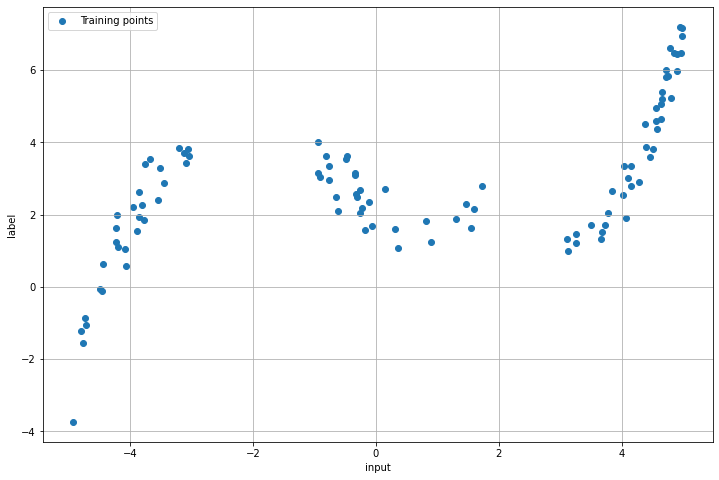

In [5]:
fig = plt.figure(figsize=(12,8))
plt.scatter(train_df.input, train_df.label, label='Training points')
plt.xlabel('input')
plt.ylabel('label')
plt.grid()
plt.legend()
plt.show()

In [6]:
train_df["input"]=(train_df["input"]-train_df["input"].min())/(train_df['input'].max() - train_df['input'].min())

test_df["input"]=(test_df["input"]-test_df["input"].min())/(test_df['input'].max() - test_df['input'].min())

**DEFINITION OF THE NETWORK**

In [7]:
class Net(nn.Module):
  """
  Nin - Input Size
  Nh1 - Neurons in first hidden layer
  Nh2 - Neurons in second hidden layer
  No - Output Size
  """

  def __init__(self, Nin, Nh1, Nh2, No):
    super().__init__()

    #print("Network with 2 hidden Layers for regression!")

    # Structure of the network
    self.fc1 = nn.Linear(in_features = Nin, out_features = Nh1)
    self.fc2 = nn.Linear(in_features = Nh1, out_features = Nh2)
    self.out = nn.Linear(in_features = Nh2, out_features = No)
    self.act = nn.Sigmoid()
  
  def forward(self, x , additional_out = False):
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.out(x)
    return x


**FUNCTION FOR TRAINING**

In [8]:
def manualTraining(train_loader, val_loader, device, num_epoch = 150, lr = 1e-3, kernel_layer = 64, weight_decay = 0):

  # Net Initialization
  Nin, Nh1, Nh2, No = [1, kernel_layer, kernel_layer, 1]
  net = Net(Nin,Nh1,Nh2,No)
  net.to(device)

  # Define Loss Function
  loss_function = nn.MSELoss()

  # Define optimizer
  optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay = weight_decay)

  # Training Phase
  train_loss_log = []
  val_loss_log = []
  for epochNum in range(num_epoch):

    # Train
    train_loss = []
    net.train() # Set the network in train mode

    for sample_batched in train_loader:
      # First we have to mode samples in gpu
      x_batch = sample_batched[0].to(device)
      label = sample_batched[1].to(device)

      out = net(x_batch)

      loss = loss_function(out, label)

      # BackPropagation
      optimizer.zero_grad()
      
      loss.backward()

      # Update the weights
      optimizer.step()

      # Save train loss for this batch
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    train_loss = np.mean(train_loss)
    train_loss_log.append(train_loss)
    # Now we check if Val_loader is provided in order to return also the validation loss
    
    if val_loader:
      val_loss = []
      net.eval() # Now we check the network so no training
      with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_loader:

          x_batch = sample_batched[0].to(device)
          label = sample_batched[1].to(device)
          # Compute Output of the model
          out = net(x_batch)
          # Compute Loss
          loss = loss_function(out,label)

          loss_batch = loss.detach().cpu().numpy()
          val_loss.append(loss_batch)

          # Since we are in the validation, No backpropagation!
        val_loss = np.mean(val_loss)
        #print("AVERAGE VALIDATION LOSS :" , val_loss)
        val_loss_log.append(val_loss)

  return train_loss_log, val_loss_log, net
    


**DEFINITION OF DATASET CLASS**

In [9]:
class pdDataset(Dataset):

  def __init__(self, xvector, yvector, transform = None):
    """
      Args:
        xvector: Series of panda which includes all x samples
        yvector: Series of panda which includes all labels
        transform (optional) : Function to apply to each sample
    """

    self.transform = transform
    self.data = [] # empty array
    for iter in range(xvector.shape[0]):
      self.data.append((xvector.iloc[iter], yvector.iloc[iter]))
    

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample
  
class ToTensor(object):
  """ Convert Sample to tensors """
  def __call__(self,sample):
    x,y = sample
    return (torch.tensor([x]).float(),
            torch.tensor([y]).float())
    
composed_transform = transforms.Compose([ToTensor()] )

**DEFINITION OF PARAMETERS FOR GRID SEARCH**



In [12]:
import itertools
# In this case we have the following parameters

kernels = (256,512,1024)
epochs = (2000,4000,5000)
learning_rates = (1e-2,1e-3,1e-4,1e-5)
batch_sizes = (80,100)
#weights_decay = (0)

gridSearch = list(itertools.product(kernels,epochs,learning_rates,batch_sizes))
resultsGridSearch = []
print("# of combinations : " , len(gridSearch))


# of combinations :  72


**KFOLD (K = 5)**

In [13]:
from tqdm.notebook import tqdm
# Check if GPU is available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")


kf5 = sklearn.model_selection.KFold(n_splits = 5, shuffle = True )

for parameters in tqdm(gridSearch):
  print("Start with parameters : ", parameters)
  # For each tuple of parameters we perform K-Fold and select the best model
  kernel_layer = parameters[0]
  epochs = parameters[1]
  learning_rate = parameters[2]
  batch_size = parameters[3]
  #weight_decay = parameters[4]


  accuracyTraining = []
  accuracyVal = []
  nets = []

  for x_train_indexes,x_val_indexes in kf5.split(train_df['input']):

    x_train, y_train = train_df.iloc[x_train_indexes]['input'] , train_df.iloc[x_train_indexes]['label']
    x_val, y_val = train_df.iloc[x_val_indexes]['input'] , train_df.iloc[x_val_indexes]['label']

    train_dataset = pdDataset(x_train, y_train, composed_transform)
    val_dataset = pdDataset(x_val, y_val, composed_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

    #a , b , net = manualTraining(train_dataloader, val_dataloader, device, epochs, learning_rate, kernel_layer, weight_decay)
    a , b , net = manualTraining(train_dataloader, val_dataloader, device, epochs, learning_rate, kernel_layer)
    accuracyTraining.append(a)
    accuracyVal.append(b)
    nets.append(net)

  # select best net w.r.t. val loss
  net_index = np.argmin(np.mean(accuracyVal[-40:]))
  net = nets[net_index]
  accuracyTraining = accuracyTraining[net_index]
  accuracyVal = accuracyVal[net_index]
  resultsGridSearch.append((net,accuracyTraining,accuracyVal,np.mean(accuracyVal),parameters))

Start with parameters :  (256, 2000, 0.01, 80)
Start with parameters :  (256, 2000, 0.01, 100)
Start with parameters :  (256, 2000, 0.001, 80)
Start with parameters :  (256, 2000, 0.001, 100)
Start with parameters :  (256, 2000, 0.0001, 80)
Start with parameters :  (256, 2000, 0.0001, 100)
Start with parameters :  (256, 2000, 1e-05, 80)
Start with parameters :  (256, 2000, 1e-05, 100)
Start with parameters :  (256, 4000, 0.01, 80)
Start with parameters :  (256, 4000, 0.01, 100)
Start with parameters :  (256, 4000, 0.001, 80)
Start with parameters :  (256, 4000, 0.001, 100)
Start with parameters :  (256, 4000, 0.0001, 80)
Start with parameters :  (256, 4000, 0.0001, 100)
Start with parameters :  (256, 4000, 1e-05, 80)
Start with parameters :  (256, 4000, 1e-05, 100)
Start with parameters :  (256, 5000, 0.01, 80)
Start with parameters :  (256, 5000, 0.01, 100)
Start with parameters :  (256, 5000, 0.001, 80)
Start with parameters :  (256, 5000, 0.001, 100)
Start with parameters :  (256, 5

In [14]:
# HERE WE FINISHED GRIDSEARCH 
minVal = 1e5 # Very high value
for i in range(len(resultsGridSearch)):
  instance = resultsGridSearch[i][2]
  if minVal > np.mean(instance[:-10]):
    optimal = i
    minVal = np.mean(instance[:-10])
print("Best configuration (kernels,epochs,learning_rate, batch size, weight_decay) w.r.t. Validation error: " , resultsGridSearch[optimal][-1] )
print("Best mean validation Loss : " ,  minVal)
accTraining = resultsGridSearch[optimal][1]
accVal = resultsGridSearch[optimal][2]

Best configuration (kernels,epochs,learning_rate, batch size, weight_decay) w.r.t. Validation error:  (512, 5000, 0.01, 100)
Best mean validation Loss :  0.36454925


Chosen the hyperparameters, we create the network

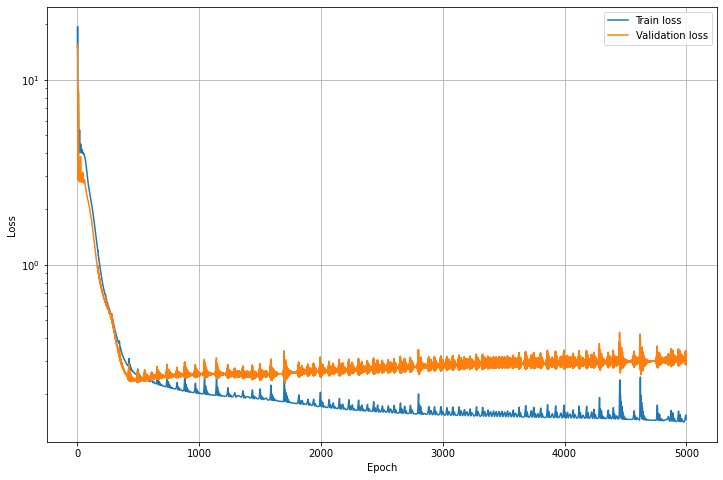

In [15]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(accTraining, label='Train loss')
plt.semilogy(accVal, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [21]:

train_dataset = pdDataset(train_df['input'], train_df['label'], composed_transform)
train_dataloader = DataLoader(train_dataset, batch_size=resultsGridSearch[optimal][-1][3], shuffle=True, num_workers=0)
accTraining, _ , net = manualTraining(train_dataloader, val_loader = None, device= device, num_epoch=resultsGridSearch[optimal][-1][1],
                                      lr=resultsGridSearch[optimal][-1][2] , kernel_layer= resultsGridSearch[optimal][-1][0])    

**Testing One Singular Net Snippet**



---------

In [122]:
#train_dataset = pdDataset(train_df['input'], train_df['label'], composed_transform)
#train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)
#accTraining, _ , net = manualTraining(train_dataloader, val_loader = None, device = device, num_epoch=15000,
                                    #  lr = 0.005 , kernel_layer= 512)

-------------

**TEST SET**

In [22]:
all_inputs = []
all_outputs = []
all_labels = []
x_test , y_test = test_df.iloc[x_val_indexes]['input'] , test_df.iloc[x_val_indexes]['label']
test_dataset = pdDataset(x_test,y_test, composed_transform)
test_dataloader = DataLoader(train_dataset, batch_size=len(test_dataset))

with torch.no_grad(): # Disable gradient tracking        
  for sample_batched in test_dataloader:
    # Move data to device
    x_batch = sample_batched[0].to(device)
    label_batch = sample_batched[1].to(device)
    # Forward pass
    out = net(x_batch)
    # Save outputs and labels
    all_inputs.append(x_batch)
    all_outputs.append(out)
    all_labels.append(label_batch)
        
# Concatenate all the outputs and labels in a single tensor
all_inputs  = torch.cat(all_inputs)
all_outputs = torch.cat(all_outputs)
all_labels  = torch.cat(all_labels)
loss_fn = nn.MSELoss()
test_loss = loss_fn(all_outputs, all_labels)
print(f"AVERAGE TEST LOSS: {test_loss}")

AVERAGE TEST LOSS: 0.14599202573299408


**PLOT OF LOSS**

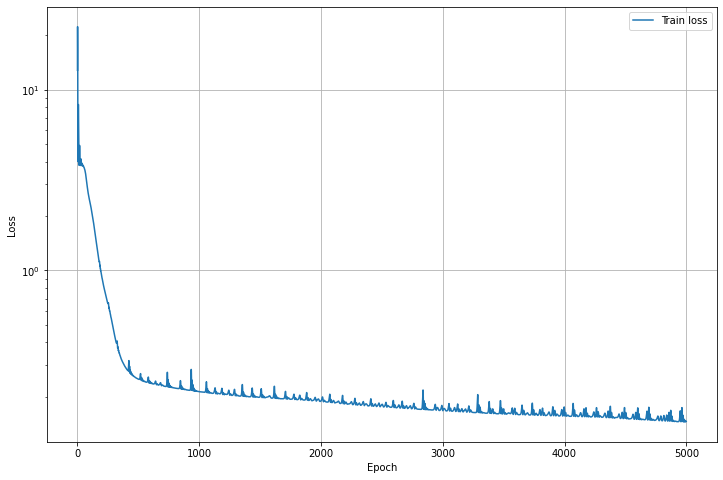

In [23]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(accTraining, label='Train loss')
#plt.semilogy(accVal, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

**PLOT OF RESULTS W.R.T. LABELS**

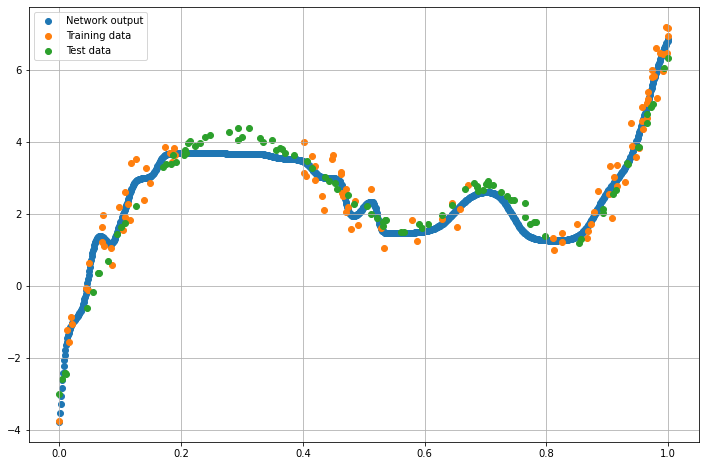

In [24]:
x_vec = torch.linspace(0,1,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)

with torch.no_grad():
  y_vec = net(x_vec)

# Plot output
plt.figure(figsize=(12,8))
plt.scatter(x_vec.cpu().numpy(), y_vec.cpu().numpy(), label='Network output')
plt.scatter(train_df['input'], train_df['label'], label='Training data')
plt.scatter(test_df['input'], test_df['label'] , label = 'Test data')
plt.grid()
plt.legend()
plt.show()


**TO DO HISTOGRAMS**

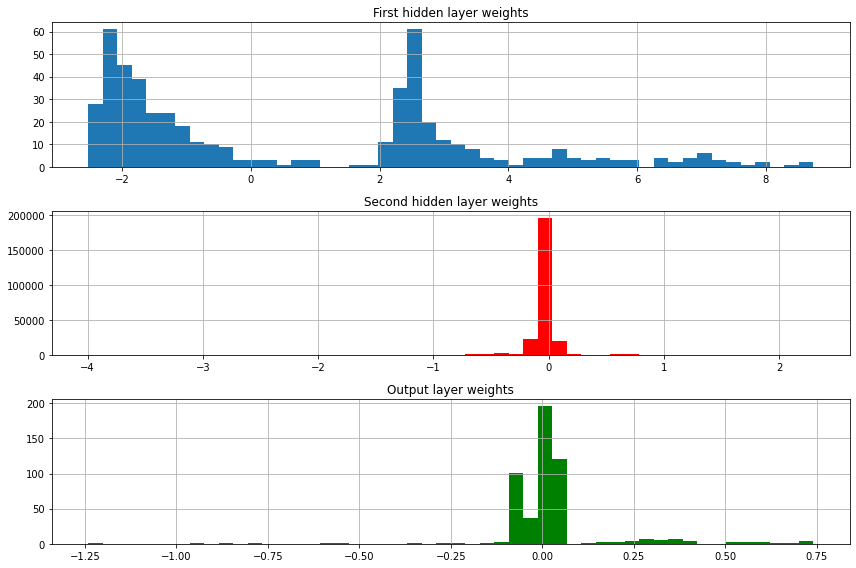

In [25]:
# First hidden layer
h1_w = net.fc1.weight.data.cpu().numpy()
h1_b = net.fc1.bias.data.cpu().numpy()

# Second hidden layer
h2_w = net.fc2.weight.data.cpu().numpy()
h2_b = net.fc2.bias.data.cpu().numpy()

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.weight.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50, color = 'red')
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50, color = 'green')
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (hand-written digit) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

## Dataset

In [26]:
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
import torch



Download the dataset:

In [27]:

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST('classifier_data', transform=trans,train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', transform=trans,train=False, download=True)

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw



Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


The output of the dataset is a PIL Image, a python object specifically developed to manage and process images. PyTorch supports this format, and there are useful transforms available natively in the framework: https://pytorch.org/docs/stable/torchvision/transforms.html

If you want, you can easily convert a PIL image to a numpy array and entirely ignore the PIL object:

**DEFINITION OF CNN ARCHITECTURE**




In [28]:
class CNN(nn.Module):


  def __init__(self, inChannel1 = 1, outChannel1 = 16, inChannel2 = 16, outChannel2 = 32, NeuronsDense = 100, dropout = 0.4):
    super().__init__()


    print("CNN for image detection!")
    # Structure of the network
    # Convolutional Layers
    self.conv1 = nn.Conv2d(in_channels = inChannel1, out_channels = outChannel1, kernel_size = 5 , padding = 2, stride = 1 )
    self.conv2 = nn.Conv2d(in_channels = inChannel2, out_channels = outChannel2, kernel_size = 5, padding = 2, stride = 1 )
    # MaxPool2D
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    # ReLU activation
    self.act = nn.ReLU()
    # Flatten Layer just before Linear layers
    self.flat = nn.Flatten()
    # dropout layer
    self.dropout = nn.Dropout(dropout)
    # Final fully Connected layers
    self.fc1 = nn.Linear(outChannel2*7*7, NeuronsDense)
    self.out = nn.Linear(NeuronsDense, 10)
    
  
  def forward(self, x , additional_out = False):
    # First Layer
    x = self.act(self.maxpool(self.conv1(x)))
    # Second Layer
    x = self.act(self.maxpool(self.conv2(x)))
    # we have now to put the sample in one dimensione just before the fully connected layer
    x = self.flat(x)
    # Dropout
    x = self.dropout(x)
    # Fully-Connected Layers
    x = self.fc1(x)
    # Output
    x = self.out(x)
    return x

**SET UP DATASETS**

In [71]:
import sklearn.model_selection as sk

num_epochs = 100
num_classes = 10
batch_size = 200
learning_rate = 0.0001

epochsLinSpace = np.arange(20, 60)
batchSizes = np.arange(50,600)
initial_valuelr = 0.1
learning_rates = [initial_valuelr/(2**j) for j in range(10)]
#weights_decay = [initial_valuelr/(2**j) for j in range(10)] 
#weights_decay.append(0)


Combinations **todo**


In [76]:
import random
N = 40 # Number of combinations to be tried
combinations = []
for i in range(N):
  listParametersChosen = []
  listParametersChosen.append(random.choice(epochsLinSpace))
  listParametersChosen.append(random.choice(batchSizes))
  listParametersChosen.append(random.choice(learning_rates))
  #listParametersChosen.append(random.choice(weights_decay))
  combinations.append(listParametersChosen)

print(combinations)

[[57, 90, 0.05], [41, 106, 0.0125], [35, 244, 0.0015625], [47, 350, 0.0015625], [46, 528, 0.0001953125], [38, 439, 0.0125], [49, 496, 0.05], [36, 364, 0.0125], [31, 324, 0.00078125], [30, 552, 0.00078125], [59, 348, 0.0125], [28, 386, 0.00078125], [36, 197, 0.000390625], [29, 80, 0.05], [27, 147, 0.00625], [41, 466, 0.000390625], [46, 197, 0.00078125], [55, 125, 0.00078125], [20, 114, 0.00625], [45, 377, 0.000390625], [21, 598, 0.0001953125], [36, 555, 0.05], [20, 98, 0.00625], [41, 542, 0.025], [38, 244, 0.0125], [57, 178, 0.0015625], [46, 392, 0.05], [50, 385, 0.0125], [44, 593, 0.05], [48, 510, 0.00625], [55, 387, 0.0125], [34, 320, 0.0001953125], [59, 192, 0.003125], [30, 240, 0.000390625], [26, 197, 0.05], [34, 447, 0.05], [33, 316, 0.003125], [56, 557, 0.0001953125], [29, 336, 0.003125], [28, 362, 0.025]]


**FUNCTION FOR TRAINING**

In [77]:
def trainingCNN(train_loader, val_loader, device, learning_rate = 0.1, num_epochs = 100, weight_decay = 0):

  model = CNN()
  model.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # Train the model
  total_step = len(train_loader)
  loss_list = []
  acc_list = []
  acc_val = []

  for epoch in tqdm(range(num_epochs)):
    # enumerate adds an integer at the beginning of the tuple image-label
    for i, (images, labels) in enumerate(train_loader):
      # Run the forward pass
      model.train()     
      optimizer.zero_grad()
      # Input of images in the cnn
      outputs = model(images.to(device))
      # evaluate Crosso Entropy Loss
      loss = criterion(outputs, labels.to(device))
      # append to log list
      loss_list.append(loss.item())

      # Backprop and perform ADAM optimisation
      loss.backward()
      optimizer.step()

      # Track the accuracy
      
      total = float(labels.size(0))
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted.to(device) == labels.to(device)).sum().item()
        

      #if (i + 1) % 90 == 0:
      #  print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}%'
      #            .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
      #                    (correct / total) * 100.0))
    acc_list.append(correct/ total * 100)
    if (correct/total == 1):
      print("Early Stopping with 100% Accuracy in training.")
      break
    
    with torch.no_grad(): # Disable gradient tracking
      correct = 0
      total = 0
      # Set model in val mode
      model.eval()
      for i, (images, labels) in enumerate(val_loader):
        outputs = model(images.to(device))
        _ , predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels.to(device)).sum().item()

    acc_val.append(correct/total * 100)
  
  return acc_list, acc_val

**TRAINING**

In [78]:
# Check if GPU is available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [79]:
from tqdm.notebook import tqdm
RandomSearchResults = []
for param in tqdm(combinations):

  train_datasetSplit, validation_dataset = sk.train_test_split(train_dataset, test_size = 0.1)
  train_load = DataLoader(dataset=train_datasetSplit, batch_size = int(param[1]), shuffle=True)
  val_load = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=False)

  accuracyTraining, accuracyValidation = trainingCNN(train_load, val_load, device, param[2], param[0], param[-1])
  RandomSearchResults.append((param,accuracyValidation, accuracyTraining))


      


CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.

CNN for image detection!



CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.

CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.

CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!



CNN for image detection!



CNN for image detection!



CNN for image detection!



CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!



CNN for image detection!



CNN for image detection!



CNN for image detection!


Early Stopping with 100% Accuracy in training.
CNN for image detection!



CNN for image detection!


Best configuration (kernels,epochs,learning_rate) w.r.t. Validation error:  [56, 557, 0.0001953125]
Best mean validation Accuracy :  99.09666666666666


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


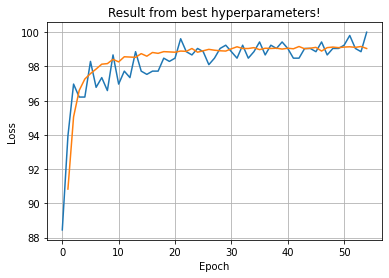

In [80]:
# End of Random Search   
maxVal = 0;
for i in range(len(RandomSearchResults)):
  instance = RandomSearchResults[i][1]
  if maxVal < np.mean(instance[-10:]):
    optimal = i
    maxVal = np.mean(instance[-10:])

print("Best configuration (kernels,epochs,learning_rate) w.r.t. Validation error: " , RandomSearchResults[optimal][0] )
print("Best mean validation Accuracy : " ,  maxVal)
accTraining = RandomSearchResults[optimal][2]
accVal = RandomSearchResults[optimal][1]

plt.figure()
plt.plot(accTraining, label='Training accuracy')
plt.plot([None] + accVal, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Result from best hyperparameters!")
plt.grid()
plt.show()
      

In [81]:
# Train with best parameters
epochs = RandomSearchResults[optimal][0][0]
lr = RandomSearchResults[optimal][0][2]
batch = RandomSearchResults[optimal][0][1]
# epochs , batch , lr = [98, 173, 0.000390625] this is an example of a solution obtained in one run

train_loader = DataLoader(dataset=train_dataset, batch_size = int(batch), shuffle=True)
model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
loss_list = []
acc_list = []
for epoch in tqdm(range(epochs)):
    # enumerate adds an integer at the beginning of the tuple image-label
    for i, (images, labels) in enumerate(train_loader):
      # Run the forward pass
      model.train()     
      optimizer.zero_grad()
      # Input of images in the cnn
      outputs = model(images.to(device))
      # evaluate Cross Entropy Loss
      loss = criterion(outputs, labels.to(device))
      # append to log list
      loss_list.append(loss.item())

      # Backprop and perform ADAM optimisation
      loss.backward()
      optimizer.step()

      # Track the accuracy
      
      total = float(labels.size(0))
      _, predicted = torch.max(outputs.data, 1)
      correct = (predicted.to(device) == labels.to(device)).sum().item()
        

      #if (i + 1) % 90 == 0:
      #  print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}%'
      #            .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
      #                    (correct / total) * 100.0))
    print("Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}%".format(epoch+1, epochs, loss.item(), correct/total * 100))
    acc_list.append(correct/ total * 100)

    if (correct/total == 1):
      print("Early Stopping with 100% Accuracy in training.")
      break



CNN for image detection!


Epoch [1/56], Loss: 0.2872, Accuracy: 91.2718%
Epoch [2/56], Loss: 0.1685, Accuracy: 95.7606%
Epoch [3/56], Loss: 0.1306, Accuracy: 96.2594%
Epoch [4/56], Loss: 0.1410, Accuracy: 95.2618%
Epoch [5/56], Loss: 0.1261, Accuracy: 95.7606%
Epoch [6/56], Loss: 0.0694, Accuracy: 98.0050%
Epoch [7/56], Loss: 0.0695, Accuracy: 98.0050%
Epoch [8/56], Loss: 0.0440, Accuracy: 99.2519%
Epoch [9/56], Loss: 0.0588, Accuracy: 98.5037%
Epoch [10/56], Loss: 0.0928, Accuracy: 98.0050%
Epoch [11/56], Loss: 0.0764, Accuracy: 98.2544%
Epoch [12/56], Loss: 0.0922, Accuracy: 97.0075%
Epoch [13/56], Loss: 0.0768, Accuracy: 97.7556%
Epoch [14/56], Loss: 0.0288, Accuracy: 99.7506%
Epoch [15/56], Loss: 0.0228, Accuracy: 99.7506%
Epoch [16/56], Loss: 0.0389, Accuracy: 99.0025%
Epoch [17/56], Loss: 0.0228, Accuracy: 99.0025%
Epoch [18/56], Loss: 0.0413, Accuracy: 98.7531%
Epoch [19/56], Loss: 0.0276, Accuracy: 99.2519%
Epoch [20/56], Loss: 0.0169, Accuracy: 99.7506%
Epoch [21/56], Loss: 0.0311, Accuracy: 99.5012%
E

In [82]:
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels.to(device)).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), 'conv_net_model.ckpt')

Test Accuracy of the model on the 10000 test images: 99.13 %


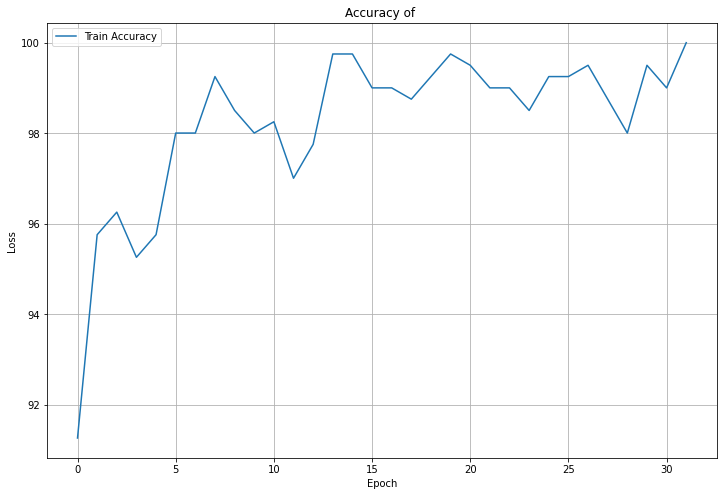

In [83]:
# Plot losses

plt.figure(figsize=(12,8))
plt.plot(acc_list, label = 'Train Accuracy')
#plt.plot(loss_list, label = 'Train Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.title("Accuracy of ")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


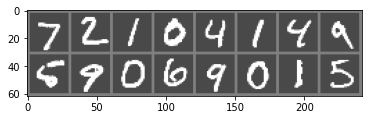

GroundTruth:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5
Predicted:      7     2     1     0     4     1     4     9     5     9     0     6     9     0     1     5


In [84]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(test_loader)
images, labels = dataiter.next()
classes = [j for j in range(0,10)]

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))

outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted.cpu().numpy()[j]]
                              for j in range(16)))

Text(0.5, 1.0, 'Confusion Matrix')

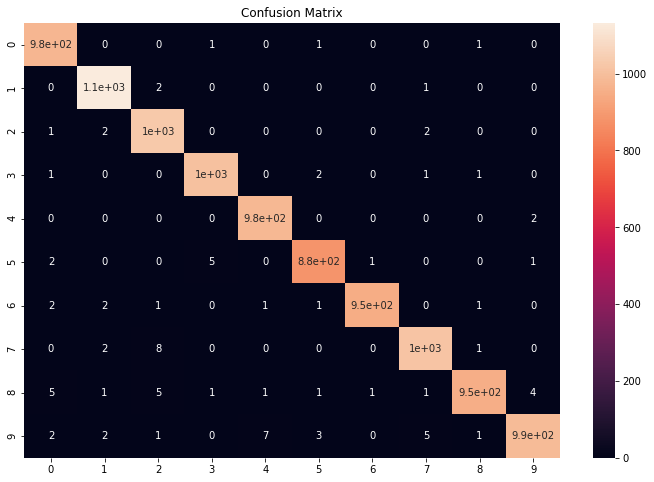

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd 
test_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)
dataiter = iter(test_loader)
images, labels = dataiter.next()
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

data = pd.DataFrame(confusion_matrix(labels, predicted.cpu().numpy()) , index = classes , columns = classes )
plt.figure(figsize = (12,8))
sn.heatmap(data, annot = True)
plt.title("Confusion Matrix")

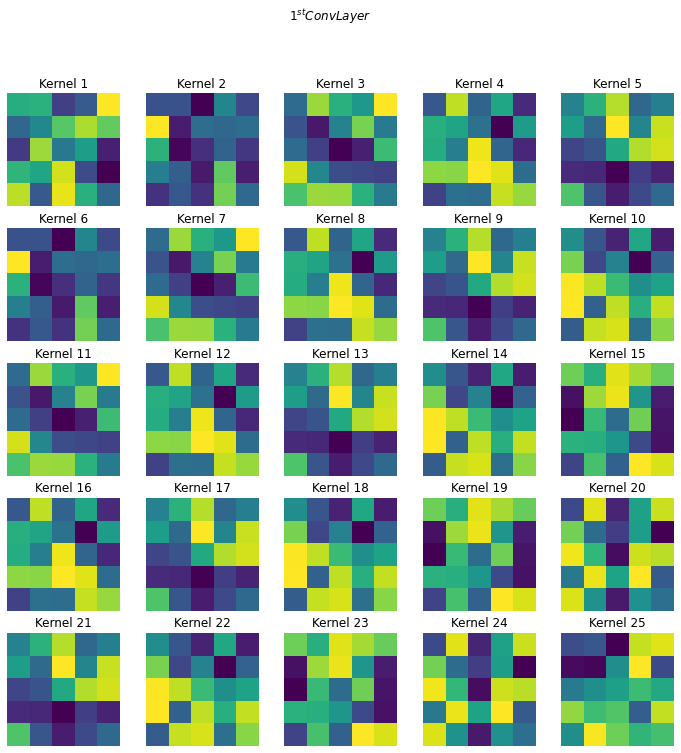

In [86]:
# Visualize feature maps


kernels1 = model.conv1.weight.detach()
kernels2 = model.conv2.weight.detach()
nrows = 5
ncolumns = 5
fig, axarr = plt.subplots(nrows,ncolumns, figsize = (12,12))
counter = 0
plt.suptitle("$1^{st} Conv Layer$")
for idx in range(nrows):
    for isx in range(ncolumns):
      
      axarr[idx,isx].imshow(kernels1[idx+isx].cpu().numpy().squeeze())
      axarr[idx,isx].axis('off')
      axarr[idx,isx].set_title("Kernel {}".format(counter+1))
      counter +=1